### Neural ODE: Project for ECE 50024
##### Zhou, Runwei

In [ ]:
# import package
! pip install torchdiffeq
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from scipy.integrate import solve_ivp
from torchvision import datasets, transforms
from torchdiffeq import odeint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ODE solver
def exponential_decay(t, z0):
  return np.exp(-z0*t)

def Spiral(t, z0):
  return torch.mm(torch.tensor([[-0.1, -1.], [1., -0.1]]), z0)

def ODE_solver(z0, t0, t1, step, f, getfull=False): 
  time_instance = torch.tensor(np.linspace(t0, t1, step))
  sol = odeint(f, z0, time_instance)
  # print(sol)
  if getfull == True:
    return sol[:,:]
  else:
    return sol[-1,:]
# print(ODE_solver(torch.tensor([[1.], [0.]]), 0., 10., 3, Spiral, getfull=False))
# print(Spiral(1, torch.tensor([[1.], [0.]])))


Text(0, 0.5, 'y')

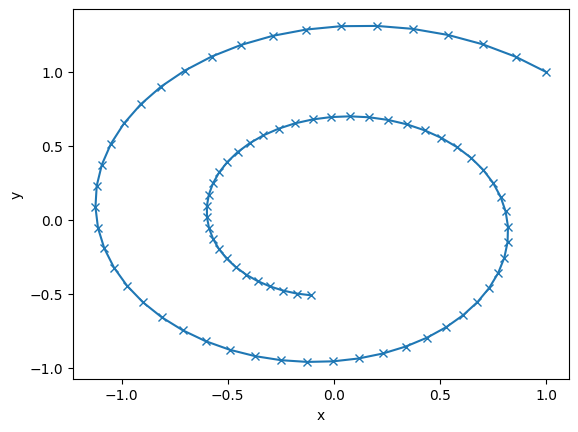

In [ ]:
# Plot sprial function
time_instance = torch.tensor(np.linspace(0, 10, 4*20))
result_ref = ODE_solver(torch.tensor([[1.],[1.]]), 0., 10., 4*20, Spiral, getfull=True)
# print(result)
# print(result[:, 0])
# plt.plot(time_instance, result[:, 0])
plt.plot(result_ref[:, 0], result_ref[:, 1], '-x')
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
# import torch
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


## Regular Net

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader



class MySpiralData(Dataset):
    def __init__(self):
        self.time_instance = torch.unsqueeze(torch.linspace(0. ,10., 4*20),dim=1)
        self.result = ODE_solver(torch.tensor([[1.],[1.]]), 0., 10., 4*20, Spiral, getfull=True)
    def __len__(self):
        return len(self.result)

    def __getitem__(self, idx):
        return self.result[idx,:].flatten(), torch.tensor([self.time_instance[idx]])

train_dataset = MySpiralData()
point, time = train_dataset[44]
print(point)
print(time)
trainloader = DataLoader(train_dataset, batch_size=1,shuffle=True)

tensor([0.8082, 0.0582])
tensor([5.5696])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.hidden1 = nn.Linear(1,20)
        self.hidden2 = nn.Linear(20,20)
        self.hidden3 = nn.Linear(20,20)  
        self.hidden4 = nn.Linear(50,10)
        self.hidden5 = nn.Linear(10,1)
        self.predict = nn.Linear(20,2)
    def forward(self, input):
        # print(input.size())
        input = input.view(-1, 1)
        out = self.hidden1(input)
        # print(out.size())
        out = F.relu(out)
        out = self.hidden2(out)
        out = F.relu(out)
        # print(out.size())
        # out = self.hidden3(out)  
        # out = F.relu(out)
        # out = self.hidden4(out)     
        # out = F.relu(out)
        # out = self.hidden5(out)
        # # out = F.relu(out)
        # print(out.size())
        out =self.predict(out)

        return out
myNet = Net()

In [ ]:
optimizer = torch.optim.Adam(myNet.parameters(),lr = 0.001)
# optimizer = torch.optim.SGD(myNet.parameters(),lr=0.01,weight_decay=0.001)
loss_func = torch.nn.MSELoss()
# loss_func = torch.nn.CrossEntropyLoss()

tensor(0.1962, grad_fn=<MseLossBackward0>)


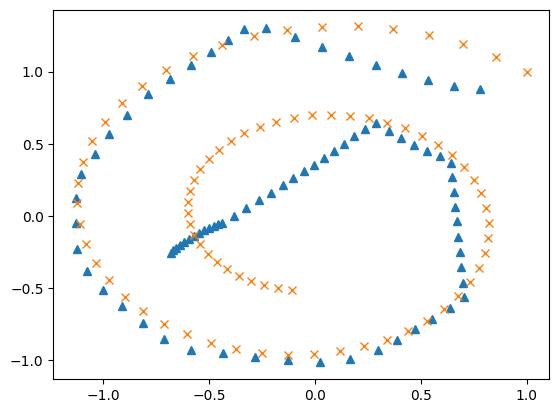

tensor(0.1328, grad_fn=<MseLossBackward0>)


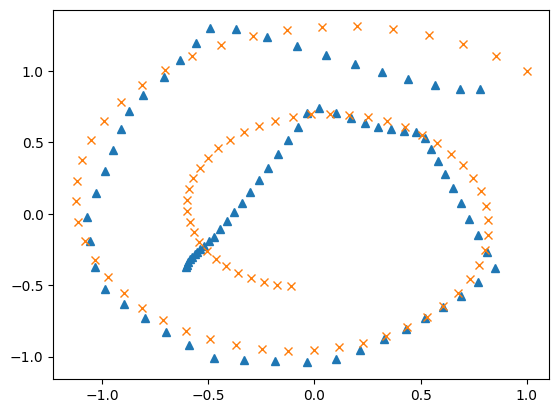

tensor(0.0880, grad_fn=<MseLossBackward0>)


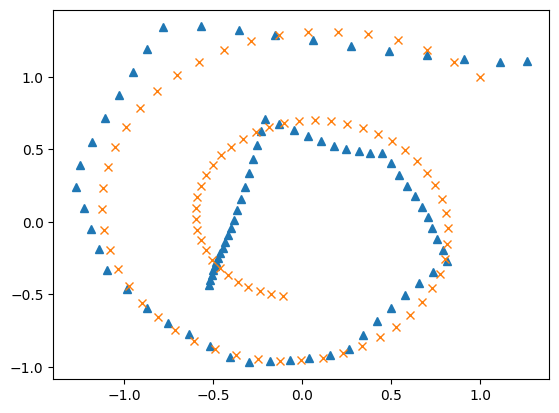

tensor(0.0735, grad_fn=<MseLossBackward0>)


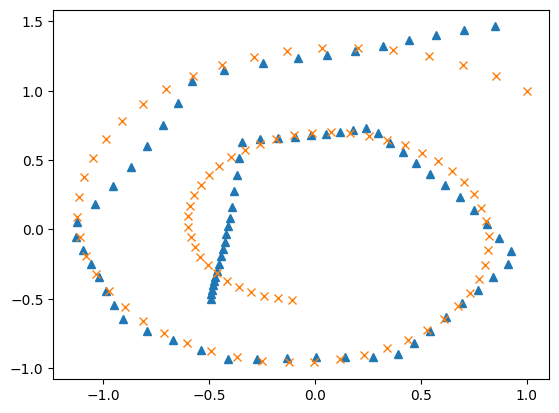

tensor(0.0497, grad_fn=<MseLossBackward0>)


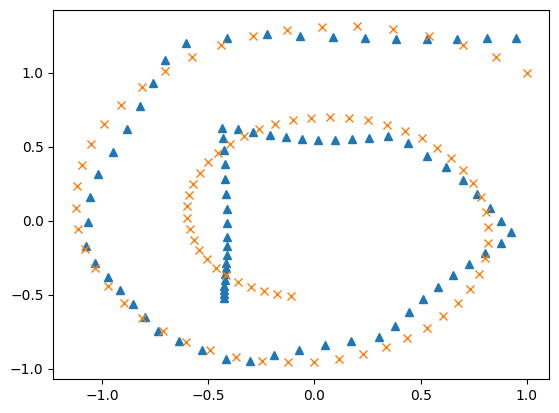

tensor(0.0439, grad_fn=<MseLossBackward0>)


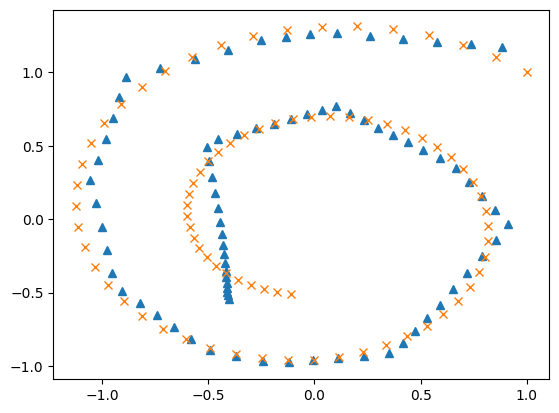

tensor(0.0394, grad_fn=<MseLossBackward0>)


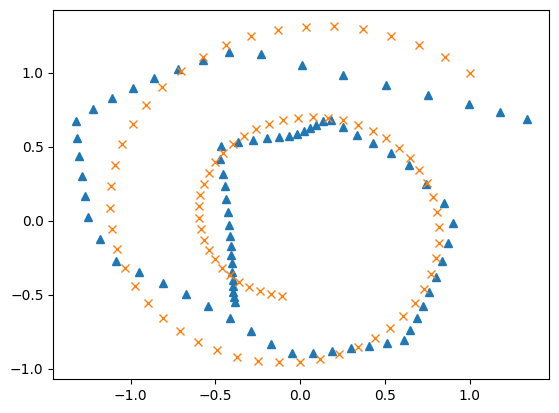

tensor(0.0273, grad_fn=<MseLossBackward0>)


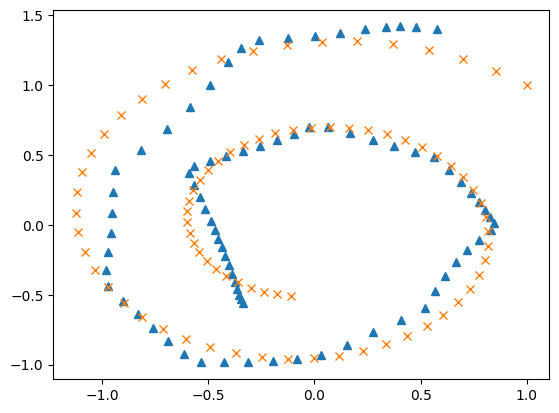

tensor(0.0180, grad_fn=<MseLossBackward0>)


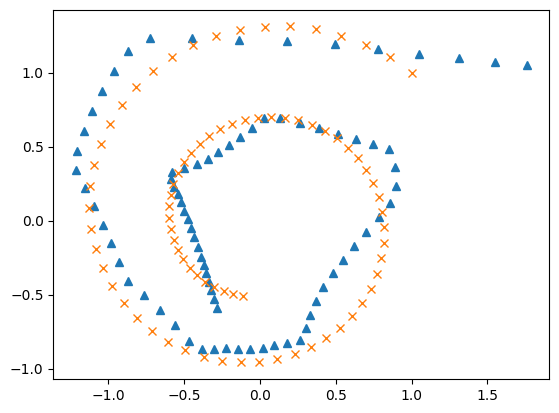

tensor(0.0194, grad_fn=<MseLossBackward0>)


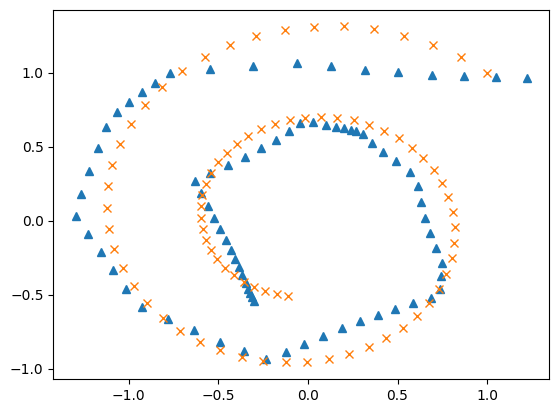

tensor(0.0146, grad_fn=<MseLossBackward0>)


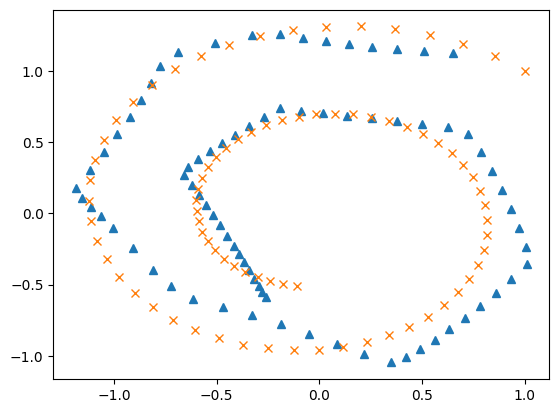

tensor(0.0152, grad_fn=<MseLossBackward0>)


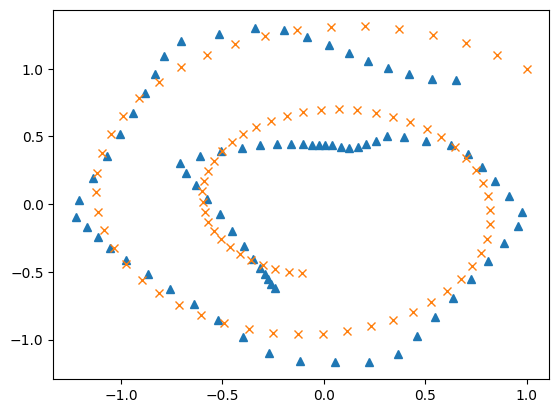

KeyboardInterrupt: ignored

In [ ]:
epoch = 2000
# time_instance = torch.tensor(np.linspace(0, 1, 51))
result = []
ref = []
for ii in range(epoch):
  for point, time in train_dataset:
    # print(point)
    # print(time)
    prediction = myNet(time)
    # print(prediction)
    # print(point)
    loss = loss_func(prediction,point)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    result.append(prediction)
    ref.append(point)
  # print(result)

  if ii%100==1:
    print(loss)
    result = torch.cat(result)
    result = torch.reshape(result, (-1, 2))   
    ref = torch.cat(ref)
    ref = torch.reshape(ref, (-1, 2))
    # print(result[:][:][-1])
    # print(result[:,0])
    # print(result[:,0].flatten())
    plt.cla()
    plt.plot(result[:,0].detach().numpy(), result[:,1].detach().numpy(), '^')  
    plt.plot(ref[:,0].detach().numpy(), ref[:,1].detach().numpy(), 'x')
    plt.show()
  result = []
  ref = []

### Neural ODE Net

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import math

class MySpiralData(Dataset):
    def __init__(self):
        self.time_instance = torch.unsqueeze(torch.linspace(0.,10., 4*10),dim=1)
        self.result = ODE_solver(torch.tensor([[1.],[1.]]), 0., 10., 4*10, Spiral, getfull=True)
    def __len__(self):
        return len(self.result)

    def __getitem__(self, idx):
        return self.result[idx,:].flatten(), torch.tensor([self.time_instance[idx]])

train_dataset = MySpiralData()
point, time = train_dataset[23]
print(point)
print(time)
trainloader = DataLoader(train_dataset, batch_size=1,shuffle=True)

tensor([0.7223, 0.3051])
tensor([5.8974])


In [ ]:
class ODEFunction(nn.Module):
    def __init__(self):
        super(ODEFunction,self).__init__()
        self.hidden1 = nn.Linear(2,4)
        self.hidden2 = nn.Linear(2,2)
        self.predict = nn.Linear(4,2)
    def forward(self, t, input):
        # print("test 3")
        # print(input)
        # input = input.view(-1, 2)
        # print("test 4")
        # print(input)
        out = self.hidden1(input)
        # out = F.relu(out)
        # out = self.hidden2(out)
        # out = F.relu(out)
        out =self.predict(out)
        # input = input.view(-1, 2)
        # print("test 5")
        # print(out)
        return out

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self):
        super(NeuralODE, self).__init__()
        self.ode = ODEFunction()
        self.div = 0.1
    def forward(self, x):
        if x[0] != 0.:
          t = torch.linspace(0, x[0], math.ceil(x[0]/self.div))
          # print("test 1")
          # print(t)
          y = odeint(self.ode, torch.tensor([[1. ,1.]]), t)       
          # print("test 2")
          # print(y)
          return y[-1,:]
        else:
          return torch.tensor([[1.],[1.]]).flatten()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.neural_ode = NeuralODE()
        self.fc = nn.Linear(2, 2)

    def forward(self, x):
        # print(x)
        y = self.neural_ode(x)
        # print(y)
        y = self.fc(y).flatten()
        return y
myNet = Net()

In [ ]:
optimizer = torch.optim.Adam(myNet.parameters(),lr = 0.001)
# optimizer = torch.optim.SGD(myNet.parameters(),lr=0.01,weight_decay=0.001)
loss_func = torch.nn.MSELoss()
# loss_func = torch.nn.CrossEntropyLoss()

tensor(0.0087, grad_fn=<MseLossBackward0>)
[tensor([0.9668, 1.0434], grad_fn=<AddBackward0>), tensor([0.6969, 1.2252], grad_fn=<ReshapeAliasBackward0>), tensor([0.3769, 1.3066], grad_fn=<ReshapeAliasBackward0>), tensor([0.0334, 1.2885], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3060,  1.1856], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6138,  1.0139], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8715,  0.7863], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0639,  0.5212], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1811,  0.2390], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2198, -0.0392], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1826, -0.2938], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0770, -0.5079], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9151, -0.6691], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7111, -0.7700], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4815, -0.8075], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2439, -0.7831], grad_fn=<ReshapeAliasBackward0>

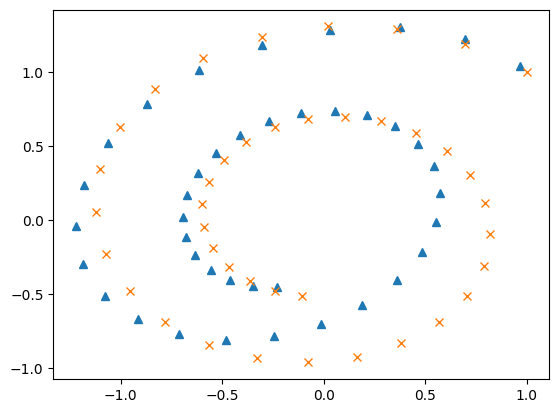

tensor(0.0013, grad_fn=<MseLossBackward0>)
[tensor([0.9829, 1.0169], grad_fn=<AddBackward0>), tensor([0.7227, 1.2040], grad_fn=<ReshapeAliasBackward0>), tensor([0.4251, 1.3038], grad_fn=<ReshapeAliasBackward0>), tensor([0.1116, 1.3142], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1964,  1.2392], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4789,  1.0884], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7189,  0.8755], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9029,  0.6176], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0216,  0.3340], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0705,  0.0442], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0498, -0.2327], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9641, -0.4797], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8219, -0.6823], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6351, -0.8294], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4179, -0.9143], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1859, -0.9342], grad_fn=<ReshapeAliasBackward0>

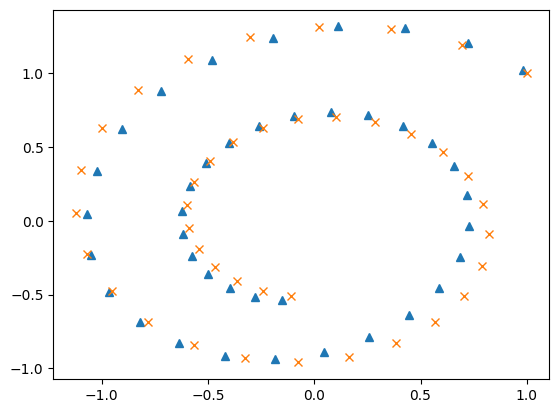

tensor(0.0002, grad_fn=<MseLossBackward0>)
[tensor([0.9722, 0.9975], grad_fn=<AddBackward0>), tensor([0.6887, 1.1845], grad_fn=<ReshapeAliasBackward0>), tensor([0.3739, 1.2856], grad_fn=<ReshapeAliasBackward0>), tensor([0.0500, 1.2987], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2617,  1.2275], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5416,  1.0810], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7734,  0.8724], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9448,  0.6184], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0477,  0.3375], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0790,  0.0490], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0402, -0.2286], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9370, -0.4781], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7792, -0.6851], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5791, -0.8384], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3517, -0.9308], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1126, -0.9591], grad_fn=<ReshapeAliasBackward0>

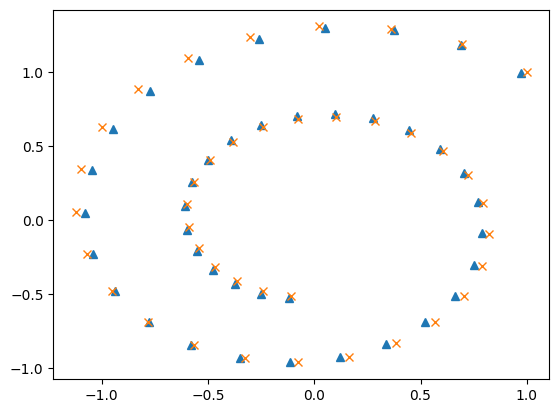

tensor(1.5223e-05, grad_fn=<MseLossBackward0>)
[tensor([0.9740, 0.9926], grad_fn=<AddBackward0>), tensor([0.6772, 1.1804], grad_fn=<ReshapeAliasBackward0>), tensor([0.3513, 1.2827], grad_fn=<ReshapeAliasBackward0>), tensor([0.0190, 1.2972], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2980,  1.2275], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5801,  1.0824], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8111,  0.8751], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9787,  0.6221], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0755,  0.3418], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0989,  0.0535], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0512, -0.2242], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9387, -0.4741], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7719, -0.6817], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5640, -0.8358], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3300, -0.9293], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0863, -0.9589], grad_fn=<ReshapeAliasBackwa

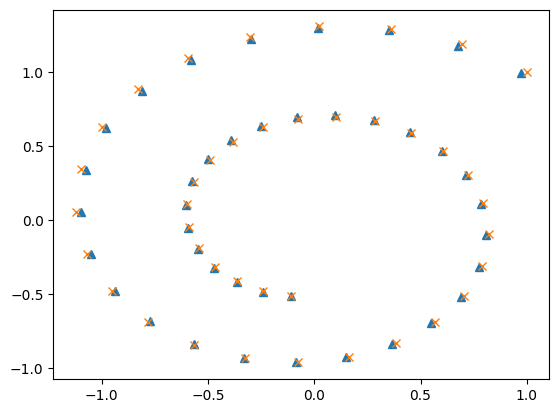

tensor(5.4162e-07, grad_fn=<MseLossBackward0>)
[tensor([0.9820, 0.9957], grad_fn=<AddBackward0>), tensor([0.6805, 1.1840], grad_fn=<ReshapeAliasBackward0>), tensor([0.3502, 1.2864], grad_fn=<ReshapeAliasBackward0>), tensor([0.0139, 1.3009], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3064,  1.2309], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5910,  1.0853], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8233,  0.8773], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9912,  0.6235], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0874,  0.3423], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1092,  0.0532], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0590, -0.2251], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9437, -0.4754], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7739, -0.6830], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5629, -0.8369], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3263, -0.9298], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0803, -0.9588], grad_fn=<ReshapeAliasBackwa

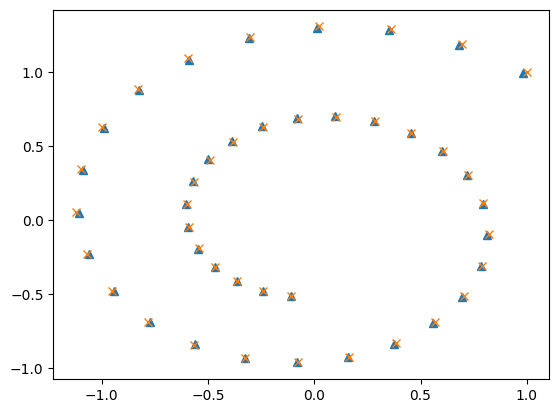

In [ ]:
epoch = 10
# time_instance = torch.tensor(np.linspace(0, 1, 51))
result = []
ref = []
for ii in range(epoch):
  for point, time in train_dataset:
    # print(point)
    # print(time)
    prediction = myNet(time)
    # print(prediction)
    # print(point)
    loss = loss_func(prediction,point)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    result.append(prediction)
    ref.append(point)
    # print(result)

  if ii%2==0:
    print(loss)
    print(result)
    result = torch.cat(result)
    result = torch.reshape(result, (-1, 2))   
    ref = torch.cat(ref)
    ref = torch.reshape(ref, (-1, 2))
    # print(result[:][:][-1])
    # print(result[:,0])
    # print(result[:,0].flatten())
    plt.cla()
    plt.plot(result[:,0].detach().numpy(), result[:,1].detach().numpy(), '^')  
    plt.plot(ref[:,0].detach().numpy(), ref[:,1].detach().numpy(), 'x')
    plt.show()
  result = []
  ref = []